In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define Models

In [2]:
import re

import numpy as np
import pandas as pd


def augment_dataset(X, y, feature_cols: list[str]):
    # Augment the X to simulate the reading progress
    dfs = []
    for chapter in range(1, 13):
        features_to_mask = [
            f for f in feature_cols if int(re.findall(r"\d+", f)[0]) > chapter
        ]
        X_masked = X.copy()
        X_masked[features_to_mask] = np.nan
        dfs.append(X_masked)

    # Concatenate the masked dataframes and labels
    augmented_x = pd.concat(dfs, ignore_index=True)
    augmented_y = pd.concat([y] * 12, ignore_index=True)

    # Shuffle augmented x and y at the same time to avoid misalignment
    augmented_x = augmented_x.sample(frac=1)
    augmented_y = augmented_y[augmented_x.index]

    return augmented_x, augmented_y

In [3]:
# TODO: move this to a separate module
# Compared with the definition in early_predictor.py, we override the `finetune` method here.

from itertools import product

import utils
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score


class OriginalModel(utils.BaseModel):
    name = "Original"

    def __init__(self, feature_cols, multi_class: bool = False):
        self.feature_cols = feature_cols
        self.multi_class = multi_class
        self.model = utils.base_prediction_pipeline(feature_cols)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_scores(self, X):
        proba = self.model.predict_proba(X)

        if self.multi_class:
            return proba
        else:
            return proba[:, 1]

    def finetune(self, X_train, y_train, X_val, y_val):
        GRID = {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
        }

        best_roc_auc = 0
        best_model = None
        best_params = None

        for param_values in product(*GRID.values()):
            params = dict(zip(GRID.keys(), param_values))
            model = utils.base_prediction_pipeline(self.feature_cols, **params)
            model.fit(X_train, y_train)

            if self.multi_class:
                y_pred_scores = model.predict_proba(X_val)
                roc_auc = roc_auc_score(
                    y_val, y_pred_scores, multi_class="ovr", average="weighted"
                )
            else:
                y_pred_scores = model.predict_proba(X_val)[:, 1]
                roc_auc = roc_auc_score(y_val, y_pred_scores)

            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = model
                best_params = params

        self.model = best_model
        self.best_params = best_params


class AugmentedModel(utils.BaseModel):
    """
    The underlying model is the same as the BaseModel (RandomForestClassifier),
    but the input data is augmented to simulate the reading progress.
    """

    name = "Augmented"

    def __init__(self, feature_cols, multi_class: bool = False):
        super().__init__(feature_cols, multi_class)
        self.multi_class = multi_class

    def fit(self, X, y):
        augmented_x, augmented_y = augment_dataset(X, y, self.feature_cols)
        self.model.fit(augmented_x, augmented_y)

    def finetune(self, X_train, y_train, X_val, y_val):
        # Augment the X to simulate the reading progress
        augmented_x, augmented_y = augment_dataset(X_train, y_train, self.feature_cols)
        val_augmented_x, val_augmented_y = augment_dataset(
            X_val, y_val, self.feature_cols
        )

        GRID = {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
        }

        best_roc_auc = 0
        best_model = None
        best_params = None

        for param_values in product(*GRID.values()):
            params = dict(zip(GRID.keys(), param_values))
            model = utils.base_prediction_pipeline(self.feature_cols, **params)
            model.fit(augmented_x, augmented_y)
            if self.multi_class:
                y_pred_scores = model.predict_proba(val_augmented_x)
                roc_auc = roc_auc_score(
                    val_augmented_y,
                    y_pred_scores,
                    multi_class="ovr",
                    average="weighted",
                )
            else:
                y_pred_scores = model.predict_proba(val_augmented_x)[:, 1]
                roc_auc = roc_auc_score(val_augmented_y, y_pred_scores)

            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = model
                best_params = params

        self.model = best_model
        self.best_params = best_params


class ChapterEnsembleModel(utils.BaseModel):
    """
    The model is an ensemble of 12 models, one for each chapter.
    Each model is trained on the features available up to the corresponding chapter.
    E.g. the model for chapter 3 is trained on the features of chapters 1, 2, and 3.

    During inference, we only use the model corresponding to the chapter being evaluated.

    Future work:
    Consider other ensemble strategies, e.g., majority voting, weighted voting, etc.
    """

    name = "Chapter Ensemble"

    def __init__(self, feature_cols, multi_class: bool = False):
        self.feature_cols = feature_cols
        self.multi_class = multi_class

        # Prepare the features for each model, up to the corresponding chapter, i.e.
        # chapter_features[0]: features for chapter 1
        # chapter_features[1]: features for chapter 1 and 2
        # ...
        self.chapter_features = [
            [f for f in self.feature_cols if int(re.findall(r"\d+", f)[0]) <= chapter]
            for chapter in range(1, 13)
        ]

        self.models = []
        for chapter in range(1, 13):
            features = self.chapter_features[chapter - 1]
            self.models.append(utils.base_prediction_pipeline(features))

    def fit(self, X, y):
        for i, model in enumerate(self.models):
            features = self.chapter_features[i]
            model.fit(X[features], y)

    def predict_scores(self, X):
        # Infer the chapter number that is currently being evaluated by check the mask of X
        num_nan = X.iloc[0].isnull().sum()
        n_features = len(self.feature_cols) // 12
        n_chapter_being_masked = int(num_nan / n_features)
        chapter = 12 - n_chapter_being_masked

        # Use the corresponding model to predict the scores
        model = self.models[chapter - 1]
        features = self.chapter_features[chapter - 1]

        if self.multi_class:
            return model.predict_proba(X[features])
        else:
            return model.predict_proba(X[features])[:, 1]

    def predict(self, X):
        scores = self.predict_scores(X)
        if self.multi_class:
            return np.argmax(scores, axis=1)
        else:
            return scores > 0.5

    def finetune(self, X_train, y_train, X_val, y_val):
        GRID = {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
        }
        for i, model in enumerate(self.models):
            features = self.chapter_features[i]

            best_roc_auc = 0
            best_model = None
            best_params = None

            for param_values in product(*GRID.values()):
                params = dict(zip(GRID.keys(), param_values))
                model = utils.base_prediction_pipeline(features, **params)

                model.fit(X_train[features], y_train)
                if self.multi_class:
                    y_pred_scores = model.predict_proba(X_val[features])
                    roc_auc = roc_auc_score(
                        y_val, y_pred_scores, multi_class="ovr", average="weighted"
                    )
                else:
                    y_pred_scores = model.predict_proba(X_val[features])[:, 1]
                    roc_auc = roc_auc_score(y_val, y_pred_scores)

                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                    best_model = model
                    best_params = params

            self.models[i] = best_model
            self.best_params = best_params


class SequencedModel(utils.BaseModel):
    name = "Sequence"

    def __init__(self, feature_cols, multi_class: bool = False):
        self.feature_cols = feature_cols
        self.multi_class = multi_class
        self.preprocessor = utils.preprocessing_pipeline(feature_cols)
        self.model = None

    def fit(self, X, y):
        X_train = self.preprocessor.fit_transform(X)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_train.reshape(-1, 12, n_features)

        if self.multi_class:
            y = to_categorical(y)

        early_stopping = EarlyStopping(
            monitor="val_roc_auc", patience=5, restore_best_weights=True, mode="max"
        )

        self.model.fit(
            X_reshaped,
            y,
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping],
            validation_split=0.2,
        )

    def predict_scores(self, X):
        X_processed = self.preprocessor.transform(X)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_processed.reshape(-1, 12, n_features)

        scores = self.model.predict(X_reshaped, verbose=0)

        if self.multi_class:
            return scores
        else:
            return scores[:, 1]

    def predict(self, X):
        scores = self.predict_scores(X)
        if self.multi_class:
            return np.argmax(scores, axis=1)
        else:
            return scores > 0.5

    def finetune(self, X_train, y_train, X_val, y_val):
        n_features = len(self.feature_cols) // 12
        X_train_processed = self.preprocessor.fit_transform(X_train)
        X_reshaped = X_train_processed.reshape(-1, 12, n_features)

        X_val_processed = self.preprocessor.transform(X_val)
        X_val_reshaped = X_val_processed.reshape(-1, 12, n_features)

        if self.multi_class:
            y_train = to_categorical(y_train)
            y_val = to_categorical(y_val)

        GRID = {
            "rnn_cls": ["rnn", "gru"],
            "rnn_units": [16, 32],
            "dense_units": [8, 16],
            # # For debugging
            # "rnn_cls": ["rnn"],
            # "rnn_units": [16],
            # "dense_units": [8],
        }

        best_roc_auc = 0
        best_model = None
        best_params = None

        for param_values in product(*GRID.values()):
            params = dict(zip(GRID.keys(), param_values))
            model = utils.create_sequence_model(
                feature_cols=self.feature_cols, multi_class=self.multi_class, **params
            )

            early_stopping = EarlyStopping(
                monitor="val_roc_auc", patience=5, restore_best_weights=True
            )

            model.fit(
                X_reshaped,
                y_train,
                epochs=100,
                batch_size=32,
                verbose=0,
                callbacks=[early_stopping],
                # validation_split=0.2,
                validation_data=(X_val_reshaped, y_val),
            )

            if self.multi_class:
                pred_scores = model.predict(X_val_reshaped, verbose=0)
                roc_auc = roc_auc_score(
                    y_val, pred_scores, multi_class="ovr", average="weighted"
                )
            else:
                pred_scores = model.predict(X_val_reshaped, verbose=0)
                roc_auc = roc_auc_score(y_val, pred_scores)

            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = model
                best_params = params

        self.model = best_model
        self.best_params = best_params


class SequenceAugmentedModel(utils.BaseModel):
    name = "Sequence Augmented"

    def __init__(self, feature_cols, multi_class: bool = False):
        self.feature_cols = feature_cols
        self.multi_class = multi_class
        self.preprocessor = utils.preprocessing_pipeline(feature_cols)
        self.model = None

    def fit(self, X, y):
        augmented_x, augmented_y = augment_dataset(X, y, self.feature_cols)
        X_train = self.preprocessor.fit_transform(augmented_x)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_train.reshape(-1, 12, n_features)

        if self.multi_class:
            augmented_y = to_categorical(augmented_y)

        early_stopping = EarlyStopping(
            monitor="val_roc_auc", patience=5, restore_best_weights=True
        )

        self.model.fit(
            X_reshaped,
            augmented_y,
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping],
            validation_split=0.2,
        )

    def predict_scores(self, X):
        X_processed = self.preprocessor.transform(X)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_processed.reshape(-1, 12, n_features)

        if self.multi_class:
            return self.model.predict(X_reshaped, verbose=0)
        else:
            return self.model.predict(X_reshaped, verbose=0)[:, 1]

    def predict(self, X):
        scores = self.predict_scores(X)
        if self.multi_class:
            return np.argmax(scores, axis=1)
        else:
            return scores > 0.5

    def finetune(self, X_train, y_train, X_val, y_val):
        augmented_x, augmented_y = augment_dataset(X_train, y_train, self.feature_cols)
        X_train_processed = self.preprocessor.fit_transform(augmented_x)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_train_processed.reshape(-1, 12, n_features)

        val_augmented_x, val_augmented_y = augment_dataset(
            X_val, y_val, self.feature_cols
        )
        X_val_processed = self.preprocessor.transform(val_augmented_x)
        X_val_reshaped = X_val_processed.reshape(-1, 12, n_features)

        if self.multi_class:
            augmented_y = to_categorical(augmented_y)
            val_augmented_y = to_categorical(val_augmented_y)

        GRID = {
            "rnn_cls": ["rnn", "gru"],
            "rnn_units": [16, 32],
            "dense_units": [8, 16],
            # # For debugging
            # "rnn_cls": ["rnn"],
            # "rnn_units": [16],
            # "dense_units": [8],
        }

        best_roc_auc = 0
        best_model = None
        best_params = None

        for param_values in product(*GRID.values()):
            params = dict(zip(GRID.keys(), param_values))
            model = utils.create_sequence_model(
                feature_cols=self.feature_cols, multi_class=self.multi_class, **params
            )

            early_stopping = EarlyStopping(
                monitor="val_roc_auc", patience=5, restore_best_weights=True
            )

            model.fit(
                X_reshaped,
                augmented_y,
                epochs=100,
                batch_size=32,
                verbose=0,
                callbacks=[early_stopping],
                # validation_split=0.2,
                validation_data=(X_val_reshaped, val_augmented_y),
            )

            if self.multi_class:
                pred_scores = model.predict(X_val_reshaped, verbose=0)
                roc_auc = roc_auc_score(
                    val_augmented_y, pred_scores, multi_class="ovr", average="weighted"
                )
            else:
                pred_scores = model.predict(X_val_reshaped, verbose=0)
                roc_auc = roc_auc_score(val_augmented_y, pred_scores)

            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = model
                best_params = params

        self.model = best_model
        self.best_params = best_params

# UCSD Data

In [4]:
ucsd_data = utils.Dataset("ucsd", multi_class=True)

In [ ]:
combined_metrics = pd.concat(
    [
        utils.evaluate_model_finetune(OriginalModel, ucsd_data, multi_class=True),
        utils.evaluate_model_finetune(AugmentedModel, ucsd_data, multi_class=True),
        utils.evaluate_model_finetune(
            ChapterEnsembleModel, ucsd_data, multi_class=True
        ),
        utils.evaluate_model_finetune(SequencedModel, ucsd_data, multi_class=True),
        utils.evaluate_model_finetune(
            SequenceAugmentedModel, ucsd_data, multi_class=True
        ),
    ],
    ignore_index=True,
)

Output()

Output()

Output()

Output()

Output()

In [15]:
combined_metrics.to_csv(f"metrics/ucsd_metrics_finetune.csv", index=False)

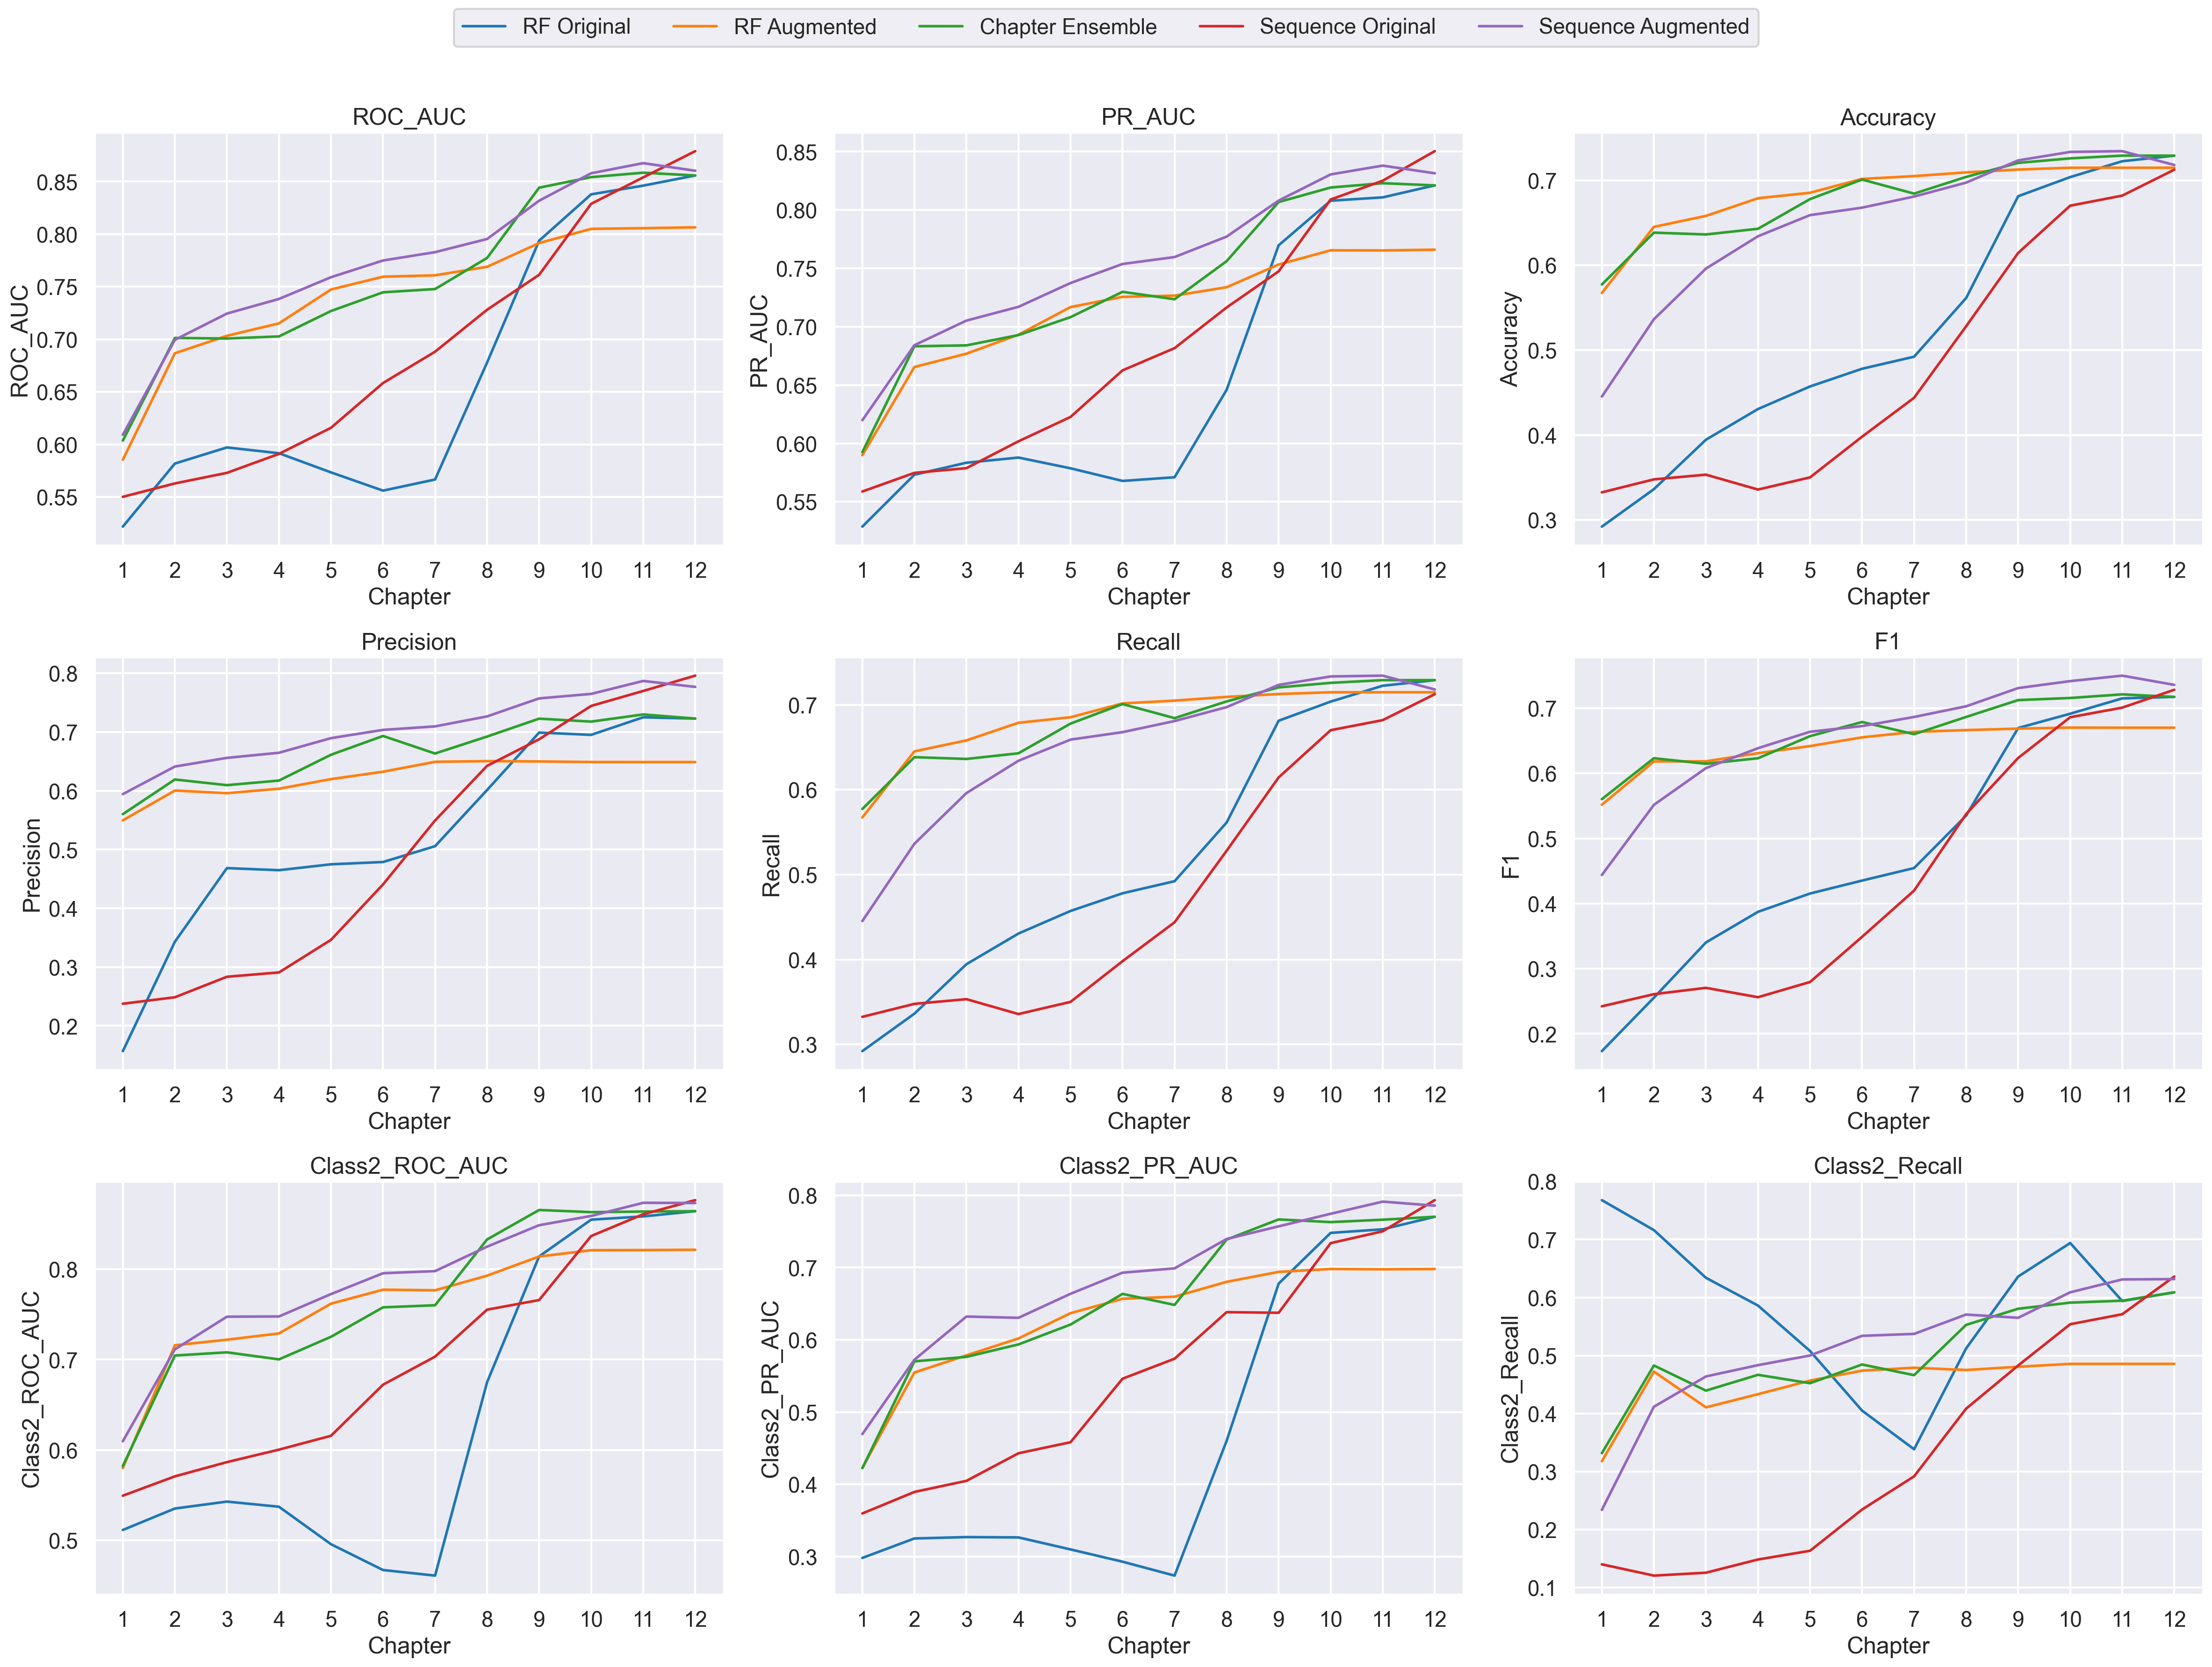

In [16]:
# matplotlib retina mode
%config InlineBackend.figure_format = 'retina'

utils.plot_metrics_subplots(combined_metrics, limit_y=False)

# Transfer from UCSD to UCLA

In [5]:
ucla_data = utils.Dataset("ucla_session_a", multi_class=True)

In [ ]:
from tqdm.notebook import tqdm

# ... existing code ...

transfer_metrics = pd.concat(
    [
        utils.evaluate_transfer_finetune(
            model_cls, ucsd_data, ucla_data, multi_class=True
        )
        for model_cls in tqdm(
            [
                OriginalModel,
                AugmentedModel,
                ChapterEnsembleModel,
                SequencedModel,
                SequenceAugmentedModel,
            ],
            desc="Evaluating models",
        )
    ],
    ignore_index=True,
)

Evaluating models:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
transfer_metrics.to_csv(f"metrics/transfer_metrics_finetune.csv", index=False)

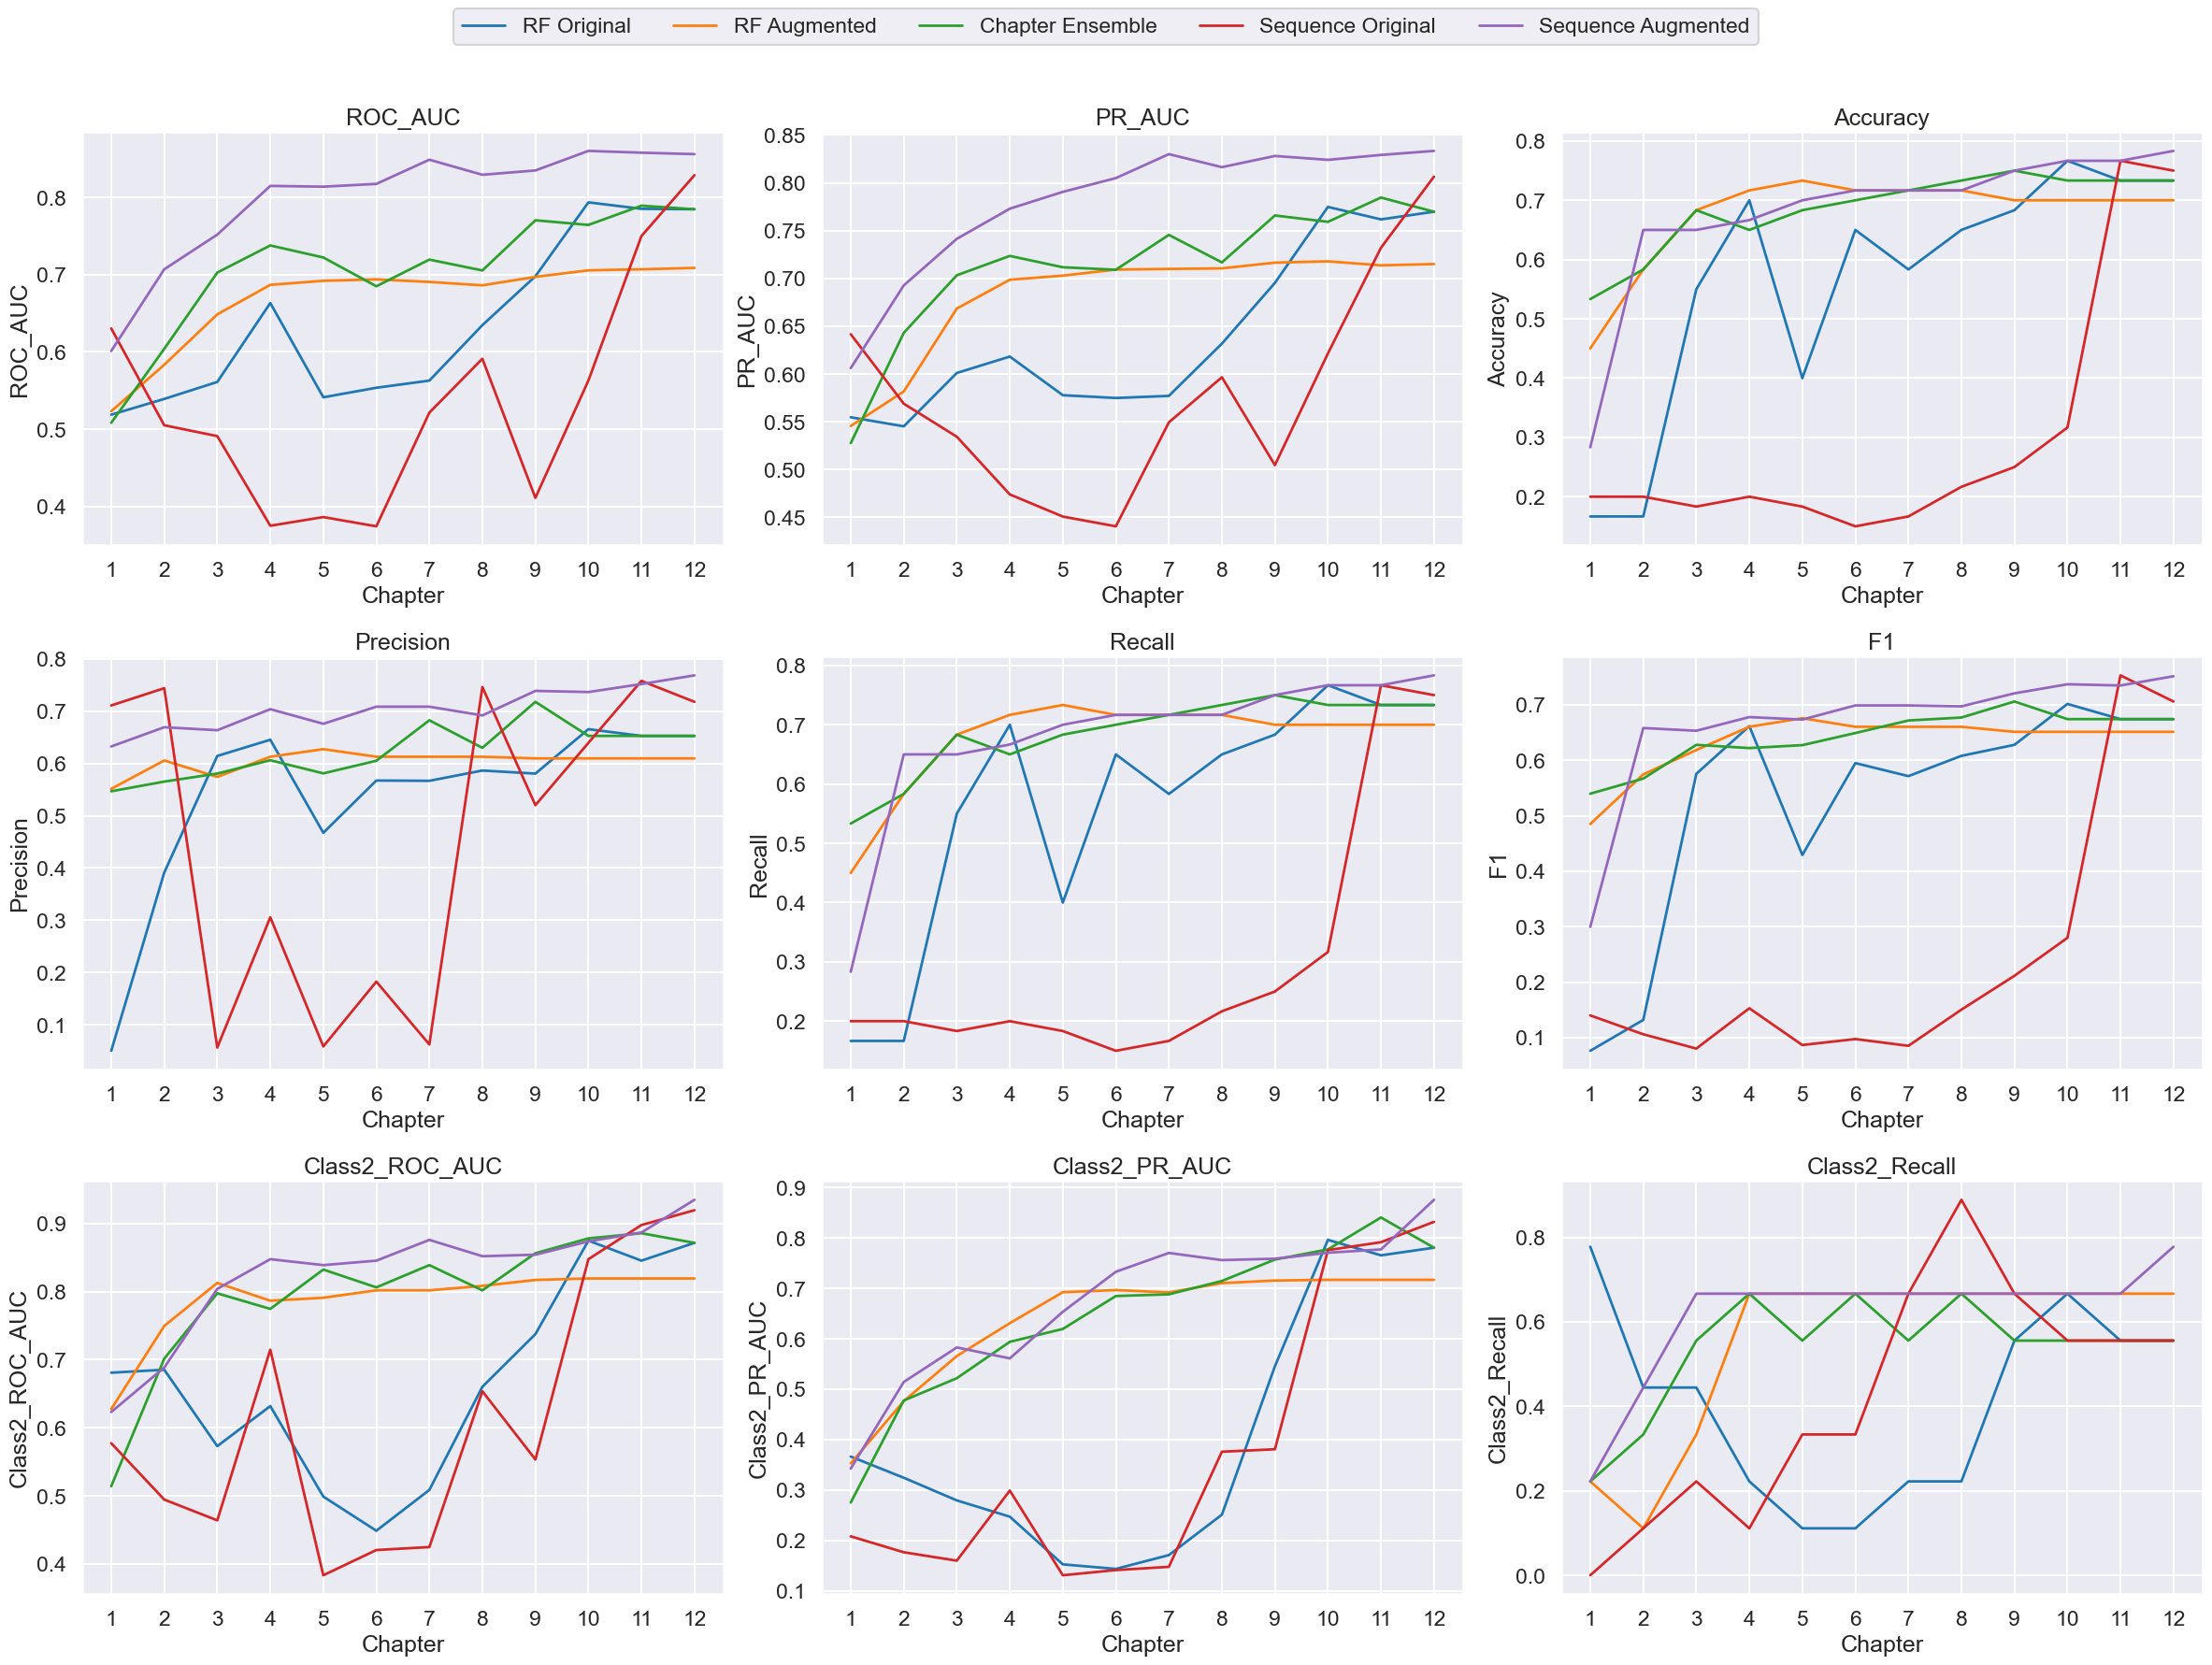

In [13]:
utils.plot_metrics_subplots(transfer_metrics, limit_y=False)

# Feature Importance

In [7]:
_, best_model = utils.evaluate_transfer_finetune(
    OriginalModel, ucsd_data, ucla_data, return_best_model=True
)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_theme(style="ticks")
sns.set_context("talk")


def plot_feature_importance(model: utils.BaseModel) -> None:
    feature_importance = model.model.named_steps["model"].feature_importances_
    feature_importance = feature_importance.reshape(12, -1).mean(axis=0)

    # Sort the features by importance in descending order
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = [model.feature_cols[i] for i in sorted_indices]
    sorted_feature_names = [c.split("_", 1)[-1] for c in sorted_feature_names]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=sorted_feature_importance, y=sorted_feature_names, ax=ax)
    ax.set_title("Feature Importance")
    ax.set_xlabel("MDI")
    ax.set_ylabel("Feature")
    plt.show()

In [ ]:
plot_feature_importance(best_model)

# Transfer from UCSD to UCLA by Feature Category

In [7]:
# Define a few models that only override the the model name
# to make the visualization easier
class SequenceAugmentedReadingModel(SequenceAugmentedModel):
    name = "Reading Related"


class SequenceAugmentedPerformanceModel(SequenceAugmentedModel):
    name = "Performance Related"

In [8]:
class DatasetExcludingFeatures(utils.Dataset):
    def __init__(self, name: str, exclude_features: list[str]):
        root = "../data/processed"
        self.data = pd.read_csv(f"{root}/{name}.csv")

        # get all feature names to exclude
        all_exclude_features = set()
        for ch in range(1, 13):
            for f in exclude_features:
                all_exclude_features.add(f"ch{ch:02d}_{f}")

        remaining_feature_cols = list(set(self.data.columns) - all_exclude_features)
        self.data = self.data[remaining_feature_cols]

        self.feature_cols = self.data.columns.drop(
            ["label", "student_id", "final_grade"]
        )

In [9]:
# Load data
ucsd_reading_data = DatasetExcludingFeatures(
    name="ucsd",
    exclude_features=["q", "pr_first", "pr_last", "attempts_mean", "summary_len"],
)
ucsd_performance_data = DatasetExcludingFeatures(
    name="ucsd", exclude_features=["n", "d_mean", "d_max", "sp_mean", "d_total", "er"]
)


ucla_reading_data = DatasetExcludingFeatures(
    name="ucla_session_a",
    exclude_features=["q", "pr_first", "pr_last", "attempts_mean", "summary_len"],
)
ucla_performance_data = DatasetExcludingFeatures(
    name="ucla_session_a",
    exclude_features=["n", "d_mean", "d_max", "sp_mean", "d_total", "er"],
)

In [12]:
transfer_by_category_metrics_seq = pd.concat(
    [
        utils.evaluate_transfer_finetune(
            SequenceAugmentedReadingModel, ucsd_reading_data, ucla_reading_data
        ),
        utils.evaluate_transfer_finetune(
            SequenceAugmentedPerformanceModel,
            ucsd_performance_data,
            ucla_performance_data,
        ),
    ],
    ignore_index=True,
)

In [15]:
# Concatenate new metrics with previous metrics
transfer_metrics = pd.concat(
    [transfer_metrics, transfer_by_category_metrics_seq], ignore_index=True
)

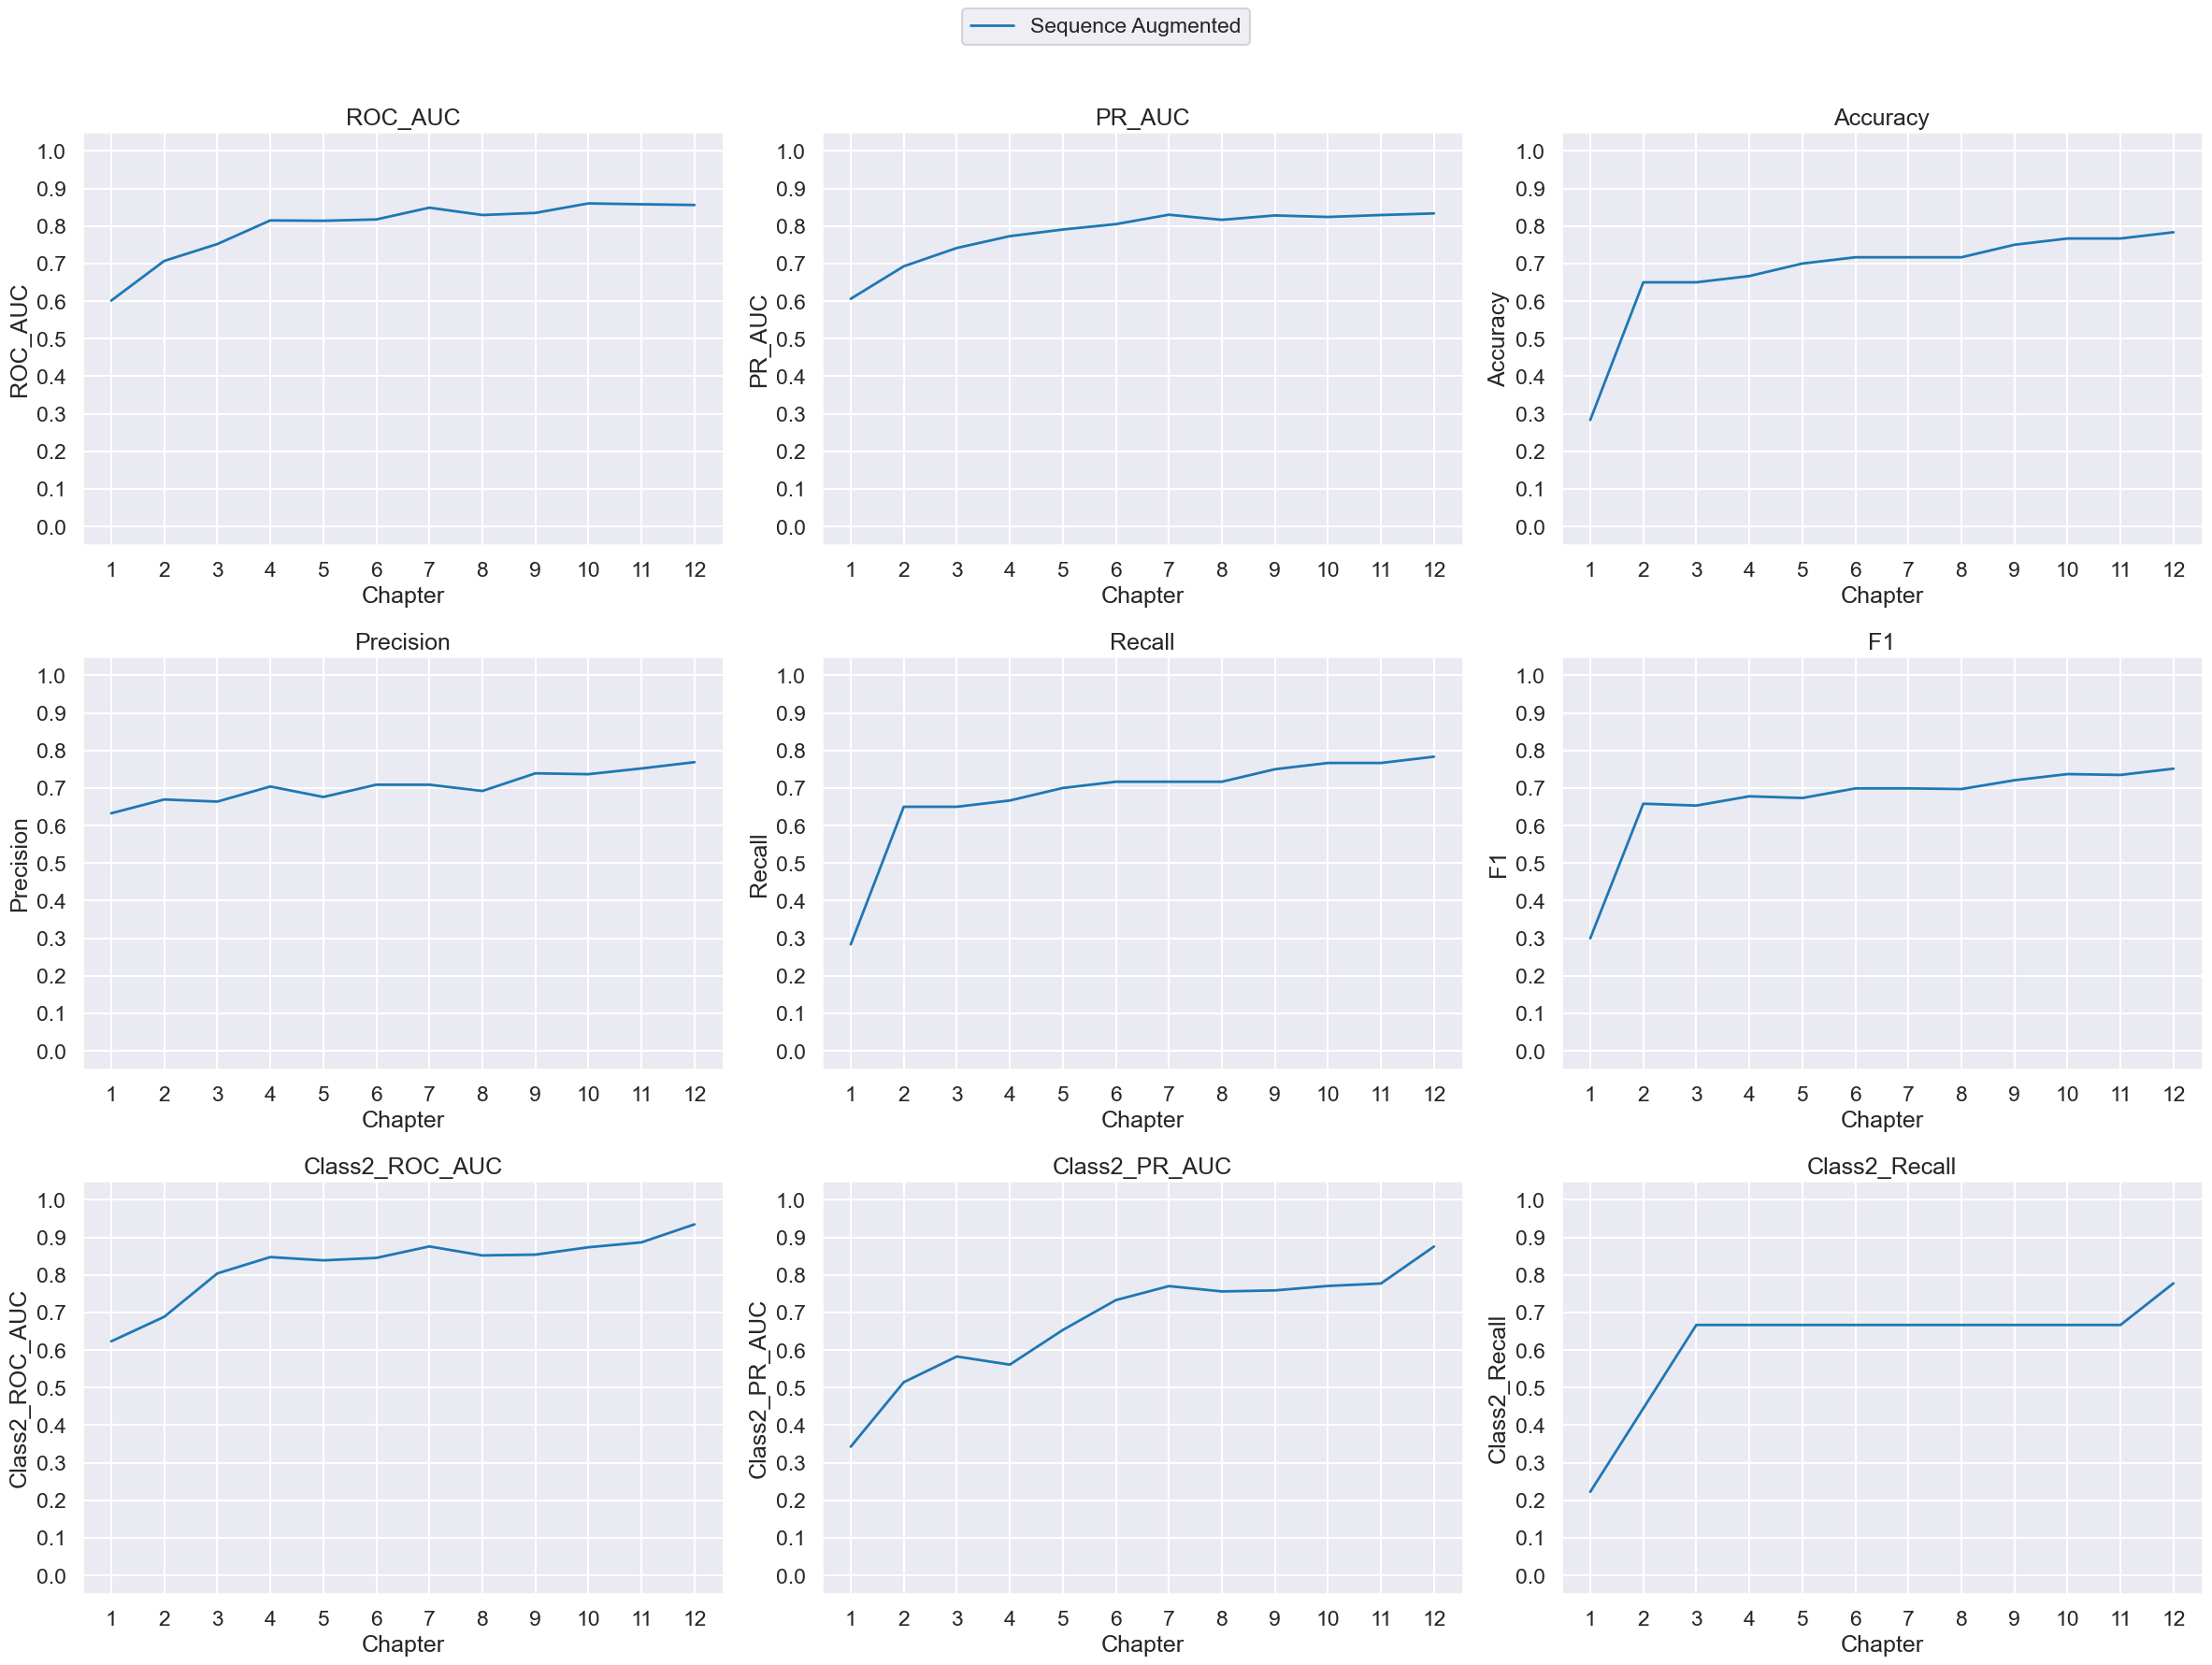

In [11]:
utils.plot_metrics_subplots(
    transfer_metrics[
        transfer_metrics["Model"].isin(
            ["Sequence Augmented", "Reading Related", "Performance Related"]
        )
    ]
)

In [17]:
transfer_metrics.to_csv(
    "metrics/transfer_metrics_finetune_with_feature_category_exp.csv", index=False
)